In [1]:
import IPython.display as ipd
import os
import pandas as pd

import glob 
import librosa
import numpy as np


### Load and Listen one of the data file

In [2]:
data = pd.read_csv('./Data/train/train.csv')

In [4]:
print(data.loc[data["ID"] == 120].Class)
ipd.Audio('Data/train/Train/'+str(120)+'.wav')


77    street_music
Name: Class, dtype: object


### Preprocessing

In [164]:
def extract_features(files):
    
    file_name = os.path.join(os.path.abspath('Data/train/Train'), str(files.ID) + '.wav')
    if not os.path.isfile(file_name):
        print(f"File not found: {file_name}")
        return None  # or handle the case as needed
    try:
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return None
    # Load an audio file as a floating point time series
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    
    # Generate Mel-frequency cepstral coefficients (MFCCs)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    
    # Computes a chromagram from a waveform or power spectrogram using Short-time Fourier transform (STFT)
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    
    # Computes a mel-scaled spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    label = files.Class

    return mfccs, chroma, mel, contrast, tonnetz, label

In [170]:
features_labels = data[:2000].apply(extract_features, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=634
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=317
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=159
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=976
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=488
  warnings.warn(
/Library/Frameworks/Pytho

In [211]:
features = []
y = []
for i in range(0, len(features_labels)):
    features.append(np.concatenate((features_labels[i][0], features_labels[i][1], 
                features_labels[i][2], features_labels[i][3],
                features_labels[i][4]), axis=0))
    y.append(features_labels[i][5])

In [212]:
labels , counts = np.unique(y, return_counts=True)

In [213]:
from sklearn.preprocessing import LabelEncoder
import torch
lb = LabelEncoder()
Y = torch.nn.functional.one_hot(torch.tensor(lb.fit_transform(y)), len(labels))
X = features

In [214]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42, stratify=Y_train_val)


### Model SetUp

In [215]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(193, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),

            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            
            nn.Linear(128, 10),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [216]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, epochs):
    """
    Plots training and validation losses in one figure and training and validation accuracy in another.
    """
    epochs_range = range(1, epochs + 1)

    # Calculate average losses and accuracies over all folds
    avg_train_loss = [sum(fold_losses) / len(fold_losses) for fold_losses in zip(*train_losses)]
    avg_val_loss = [sum(fold_losses) / len(fold_losses) for fold_losses in zip(*val_losses)]
    avg_train_accuracy = [sum(fold_accs) / len(fold_accs) for fold_accs in zip(*train_accuracies)]
    avg_val_accuracy = [sum(fold_accs) / len(fold_accs) for fold_accs in zip(*val_accuracies)]

    # Training and Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, avg_train_loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, avg_val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Training and Validation Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, avg_train_accuracy, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, avg_val_accuracy, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [207]:
import torch.optim as optim
from sklearn.model_selection import KFold

def train_model(model, X, Y, epochs=50,  lr=0.001, batch_size=32, n_splits=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Define the cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Convert data to tensors
    X = torch.tensor(X, dtype=torch.float32).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).to(device)

     # Track losses and accuracies for plotting
    all_train_losses = []
    all_train_accuracies = []
    all_val_losses = []
    all_val_accuracies = []

    fold = 1
    for train_index, val_index in kf.split(X):
        print(f"Fold {fold}/{n_splits}")
        
        # Split into train and validation sets
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        # Create DataLoader for training
        train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Reset the model parameters for each fold
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Track losses for each fold
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        # Training loop for this fold
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs, 1)
                targets = torch.argmax(batch_y, dim=1)  # Convert one-hot labels to indices
                correct_train += (predicted == targets).sum().item()
                total_train += targets.size(0)

            train_losses.append(running_loss / len(train_loader))
            train_accuracies.append(correct_train /total_train)

            # Evaluate the model
            model.eval()
            with torch.no_grad():
                outputs = model(X_val)
                val_loss = criterion(outputs, Y_val).item()
                _, predicted = torch.max(outputs, 1)
                targets = torch.argmax(Y_val, dim=1) 
                accuracy = (predicted == targets).sum().item() / len(Y_val)
                val_losses.append(val_loss)
                val_accuracies.append(accuracy)

            if epoch % 10 == 9:
                print(f'Fold {fold} - Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.2f}, Train Accuracy: {(correct_train /total_train)* 100:.2f}%,Val Loss: {val_loss:.2f}, Val Accuracy: {accuracy * 100:.2f}%')
        # Store losses and accuracy for the fold
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_losses.append(val_losses)
        all_val_accuracies.append(val_accuracies)
        
        fold+=1
    plot_metrics(all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, epochs)
    return model


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_3369/785691977.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32).to(device)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Fold 1/5
Fold 1 - Epoch 10/50, Loss: 1.92, Train Accuracy: 53.75%,Val Loss: 1.98, Val Accuracy: 48.75%
Fold 1 - Epoch 20/50, Loss: 1.80, Train Accuracy: 66.67%,Val Loss: 1.84, Val Accuracy: 61.25%
Fold 1 - Epoch 30/50, Loss: 1.73, Train Accuracy: 73.33%,Val Loss: 1.82, Val Accuracy: 64.58%
Fold 1 - Epoch 40/50, Loss: 1.70, Train Accuracy: 75.94%,Val Loss: 1.80, Val Accuracy: 65.83%
Fold 1 - Epoch 50/50, Loss: 1.68, Train Accuracy: 78.33%,Val Loss: 1.77, Val Accuracy: 68.75%
Fold 2/5
Fold 2 - Epoch 10/50, Loss: 1.65, Train Accuracy: 81.15%,Val Loss: 1.66, Val Accuracy: 80.83%
Fold 2 - Epoch 20/50, Loss: 1.65, Train Accuracy: 81.35%,Val Loss: 1.64, Val Accuracy: 82.08%
Fold 2 - Epoch 30/50, Loss: 1.65, Train Accuracy: 81.56%,Val Loss: 1.66, Val Accuracy: 80.42%
Fold 2 - Epoch 40/50, Loss: 1.63, Train Accuracy: 83.54%,Val Loss: 1.67, Val Accuracy: 78.33%
Fold 2 - Epoch 50/50, Loss: 1.61, Train Accuracy: 84.58%,Val Loss: 1.71, Val Accuracy: 75.83%
Fold 3/5
Fold 3 - Epoch 10/50, Loss: 1.60,

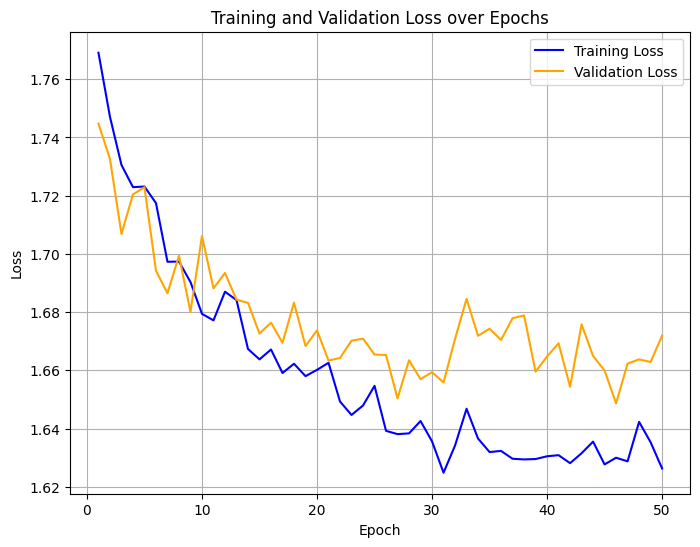

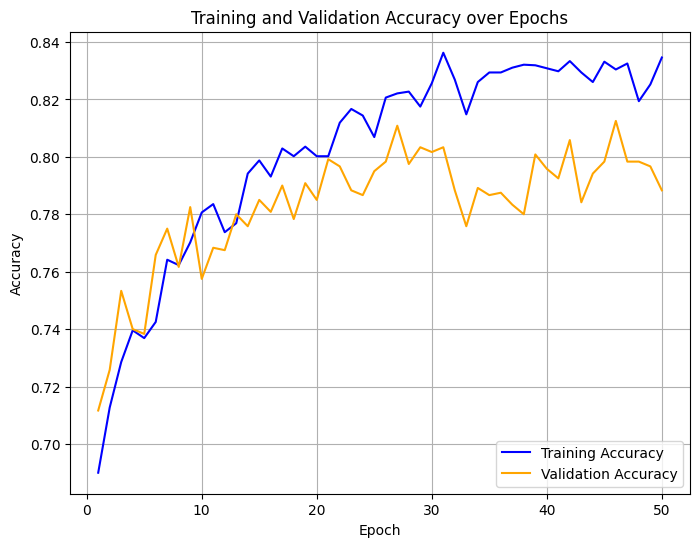

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=193, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): Softmax(dim=None)
  )
)

In [217]:
model = NeuralNetwork(0.1)

train_model(model, X=X_train, Y= Y_train)

In [236]:
import random
def test_model(model, X, Y, lb):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    ran = random.randint(0, 400)

    # Convert data to tensors
    X = torch.tensor(X, dtype=torch.float32).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).to(device)
    
    model = model.to(device)
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        targets = torch.argmax(Y, dim=1) 
        accuracy = (predicted == targets).sum().item() / len(Y)
        predict_label = lb.inverse_transform(predicted.cpu().numpy()) 
        true_labels = lb.inverse_transform(targets.cpu().numpy()) 

        print(f' Accuracy: {accuracy* 100:.2f}%, Predict: {predict_label[ran]}, Ground Truth: {true_labels[ran]}')

        


In [238]:
test_model(model, X_test, Y_test, lb)

 Accuracy: 76.00%, Predict: jackhammer, Ground Truth: jackhammer


/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_3369/2168471473.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32).to(device)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
